# Unit 5 - Financial Planning

In [1]:
# Initial imports
import os
import requests
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import json

%matplotlib inline

In [2]:
# Load .env enviroment variables
env_loc = '.env'
load_dotenv(env_loc)

True

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [3]:
# Set current amount of crypto assets
my_btc = 1.2
my_eth = 5.3

In [4]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=CAD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=CAD"

In [5]:
# Fetch current BTC price
btc_call = requests.get(btc_url)
btc_data = btc_call.content
btc = btc_call.json()
#print(json.dumps(btc, indent=4))
btc_sym = btc['data']['1']['symbol']
btc_usd = btc['data']['1']['quotes']['USD']['price']
print('Current {} price is: ${}'.format(btc_sym, btc_usd))

# Fetch current ETH price
eth_call = requests.get(eth_url)
eth_data = eth_call.content
eth = eth_call.json()
#print(json.dumps(eth, indent=4))
eth_sym = eth['data']['1027']['symbol']
eth_usd = eth['data']['1027']['quotes']['USD']['price']
print('Current {} price is: ${}'.format(eth_sym, eth_usd))

# Compute current value of my crypto
btc_val = btc_usd * my_btc
eth_val = eth_usd * my_eth

# Print current crypto wallet balance
print(f"The current value of your {my_btc} BTC is ${btc_val:0.2f}")
print(f"The current value of your {my_eth} ETH is ${eth_val:0.2f}")

Current BTC price is: $27753.0
Current ETH price is: $1863.14
The current value of your 1.2 BTC is $33303.60
The current value of your 5.3 ETH is $9874.64


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [6]:
# Set current amount of shares
my_agg = 200
my_spy = 50

In [7]:
# Set Alpaca API keys
alp_api_key = os.getenv("ALPACA_API_KEY")
alp_sec_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API
alpaca = tradeapi.REST(
    alp_api_key,
    alp_sec_key,
    api_version="v2")

In [8]:
# Format current date as ISO format
today = pd.Timestamp("2020-07-14", tz="America/New_York").isoformat()

# Set the tickers
tickers = ['AGG', 'SPY']

# Set timeframe to "1Day" for Alpaca API
timeframe = "1Day"

# Get current closing prices for SPY and AGG
close = alpaca.get_bars(
            tickers,
            timeframe,
            start = today,
            end = today
).df

#close
# Reorganize the DataFrame
# Separate ticker data
SPY = close[close['symbol']=='SPY'].drop('symbol', axis=1)
AGG = close[close['symbol']=='AGG'].drop('symbol', axis=1)

# Concatenate the ticker DataFrames
close = pd.concat([SPY, AGG], axis=1, keys=['SPY','AGG'])
close

SPY                                               \
                            open    high    low   close    volume trade_count   
timestamp                                                                       
2020-07-14 04:00:00+00:00  313.3  319.76  312.0  318.93  93545651      580270   

                                          AGG                          \
                                 vwap    open    high     low   close   
timestamp                                                               
2020-07-14 04:00:00+00:00  316.244144  118.58  118.74  118.58  118.67   

                                                            
                            volume trade_count        vwap  
timestamp                                                   
2020-07-14 04:00:00+00:00  3986756       14580  118.667216

In [9]:
# Pick AGG and SPY close prices
spy_close = float(close['SPY']['close'])
agg_close = float(close['AGG']['close'])

# Print AGG and SPY close prices
print(f"Current SPY closing price: ${spy_close}")
print(f"Current AGG closing price: ${agg_close}")

Current SPY closing price: $318.93
Current AGG closing price: $118.67


In [10]:
# Compute the current value of shares
spy_val = my_spy * spy_close
agg_val = my_agg * agg_close

# Print current value of shares
print(f"The current value of your {my_spy} SPY shares is ${spy_val:0.2f}")
print(f"The current value of your {my_agg} AGG shares is ${agg_val:0.2f}")

The current value of your 50 SPY shares is $15946.50
The current value of your 200 AGG shares is $23734.00


### Savings Health Analysis

In [11]:
# Set monthly household income
monthly_income = 12000

# Consolidate financial assets data
fin_assets = {
    'crypto': [btc_val + eth_val],
    'shares': [spy_val + agg_val]
}

# Create savings DataFrame
assets_df = pd.DataFrame(fin_assets)
assets_df = pd.DataFrame.transpose(assets_df)
assets_df.columns = ['amount']


# Display savings DataFrame
display(assets_df)

amount
crypto  43178.242
shares  39680.500

<Axes: title={'center': 'Composition of Personal Savings'}, ylabel='amount'>

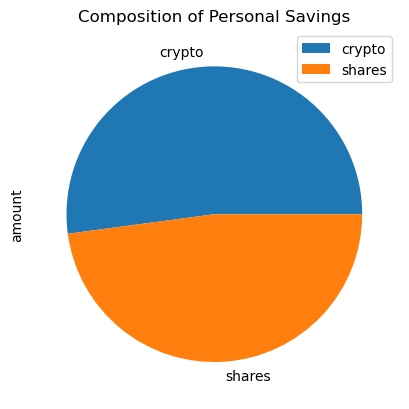

In [12]:
# Plot savings pie chart
assets_df.plot.pie(y="amount", title="Composition of Personal Savings")

In [13]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings
crypto = round(assets_df.loc['crypto'][0],2)
shares = round(assets_df.loc['shares'][0],2)
ps = crypto + shares

# Validate saving health
if ps > emergency_fund:
    print('Safe as houses mate!')
elif ps == emergency_fund:
    print('Pretty much there, but keep going!')
else:
    shortfall = emergency_fund - ps
    print('Cut back on the partying. You are ${} away from where you need to be.'.format(shortfall))



Safe as houses mate!


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [14]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
start_date = pd.Timestamp('2016-05-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2021-05-01', tz='America/New_York').isoformat()

In [15]:
# Get 5 years' worth of historical data for SPY and AGG
tickers = ['SPY', 'AGG']
timeframe = '1Day'
df_stock_data = alpaca.get_bars(
    tickers,
    timeframe,
    start = start_date,
    end = end_date    
).df

# Reorganize the DataFrame
# Separate ticker data
SPY = df_stock_data[df_stock_data['symbol']=='SPY'].drop('symbol', axis=1)
AGG = df_stock_data[df_stock_data['symbol']=='AGG'].drop('symbol', axis=1)

# Concatenate the ticker DataFrames
df_stock_data = pd.concat([SPY, AGG],axis=1, keys=['SPY','AGG'])

# Display sample data
df_stock_data.head()

SPY                                       \
                             open    high     low     close     volume   
timestamp                                                                
2016-05-02 04:00:00+00:00  206.92  208.18  206.41  207.9700   61908515   
2016-05-03 04:00:00+00:00  206.52  206.80  205.28  206.1592  106422142   
2016-05-04 04:00:00+00:00  204.99  205.85  204.42  205.0100   92199810   
2016-05-05 04:00:00+00:00  205.56  205.98  204.47  204.9700   67597222   
2016-05-06 04:00:00+00:00  204.08  205.77  203.88  205.7200   89131004   

                                                      AGG                      \
                          trade_count        vwap    open      high       low   
timestamp                                                                       
2016-05-02 04:00:00+00:00      263580  207.294812  110.74  110.7400  110.5200   
2016-05-03 04:00:00+00:00      377518  206.312060  110.89  110.9450  110.7500   
2016-05-04 04:00:00+00:00      345261  205.090172  110.91  110.9315  110.7595   
2016-05-05 04:00:00+00:00      280622  205.141555  110.92  111.1600  110.8010   
2016-05-06 04:00:00+00:00      340335  204.937074  111.12  111.1200  110.9700   

                                                                     
                             close   volume trade_count        vwap  
timestamp                                                            
2016-05-02 04:00:00+00:00  110.605  3553939       15119  110.627199  
2016-05-03 04:00:00+00:00  110.810  3044940       15662  110.865995  
2016-05-04 04:00:00+00:00  110.860  2920608       13982  110.879063  
2016-05-05 04:00:00+00:00  111.140  3008142       15707  111.028363  
2016-05-06 04:00:00+00:00  110.970  2718710       12697  111.031967

In [16]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
mc30cr = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.40,.60],
    num_simulation = 500,
    num_trading_days = 252*30
)

In [17]:
# Printing the simulation input data
mc30cr.portfolio_data.head()

SPY                                       \
                             open    high     low     close     volume   
timestamp                                                                
2016-05-02 04:00:00+00:00  206.92  208.18  206.41  207.9700   61908515   
2016-05-03 04:00:00+00:00  206.52  206.80  205.28  206.1592  106422142   
2016-05-04 04:00:00+00:00  204.99  205.85  204.42  205.0100   92199810   
2016-05-05 04:00:00+00:00  205.56  205.98  204.47  204.9700   67597222   
2016-05-06 04:00:00+00:00  204.08  205.77  203.88  205.7200   89131004   

                                                                   AGG  \
                          trade_count        vwap daily_return    open   
timestamp                                                                
2016-05-02 04:00:00+00:00      263580  207.294812          NaN  110.74   
2016-05-03 04:00:00+00:00      377518  206.312060    -0.008707  110.89   
2016-05-04 04:00:00+00:00      345261  205.090172    -0.005574  110.91   
2016-05-05 04:00:00+00:00      280622  205.141555    -0.000195  110.92   
2016-05-06 04:00:00+00:00      340335  204.937074     0.003659  111.12   

                                                                             \
                               high       low    close   volume trade_count   
timestamp                                                                     
2016-05-02 04:00:00+00:00  110.7400  110.5200  110.605  3553939       15119   
2016-05-03 04:00:00+00:00  110.9450  110.7500  110.810  3044940       15662   
2016-05-04 04:00:00+00:00  110.9315  110.7595  110.860  2920608       13982   
2016-05-05 04:00:00+00:00  111.1600  110.8010  111.140  3008142       15707   
2016-05-06 04:00:00+00:00  111.1200  110.9700  110.970  2718710       12697   

                                                    
                                 vwap daily_return  
timestamp                                           
2016-05-02 04:00:00+00:00  110.627199          NaN  
2016-05-03 04:00:00+00:00  110.865995     0.001853  
2016-05-04 04:00:00+00:00  110.879063     0.000451  
2016-05-05 04:00:00+00:00  111.028363     0.002526  
2016-05-06 04:00:00+00:00  111.031967    -0.001530

In [18]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
mc30cr.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 110.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 120.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 130.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 140.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 150.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 160.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 170.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 180.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 190.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 200.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 210.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 220.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 230.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 240.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 250.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 260.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 270.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 280.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 290.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 300.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 310.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 320.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 330.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 340.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 350.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 360.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 370.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 380.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 390.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 400.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 410.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 420.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 430.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 440.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 450.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 460.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 470.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 480.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 490.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

0         1         2         3         4         5         6    \
0      1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1      0.999373  1.007191  0.999438  1.001284  1.003453  1.000661  1.004843   
2      1.001757  1.017851  0.989471  1.002657  1.002935  0.995402  1.003970   
3      1.005244  1.013990  0.993805  1.009349  1.011669  1.002198  1.013577   
4      1.010811  1.021273  0.993164  1.020854  1.011881  1.003349  1.008910   
...         ...       ...       ...       ...       ...       ...       ...   
7556  13.436495  4.393659  6.340687  7.604231  5.723684  3.953594  4.123458   
7557  13.368652  4.425736  6.312459  7.645842  5.708557  3.969785  4.117239   
7558  13.385809  4.460940  6.286517  7.622862  5.709196  3.980057  4.086809   
7559  13.381486  4.468035  6.331913  7.678454  5.711961  4.010319  4.078307   
7560  13.441055  4.478725  6.347854  7.683813  5.735419  4.011596  4.068873   

           7         8         9    ...       490       491        492  \
0     1.000000  1.000000  1.000000  ...  1.000000  1.000000   1.000000   
1     1.003133  1.008516  1.003168  ...  0.996303  0.999220   0.999046   
2     0.997058  1.008842  1.000843  ...  0.997693  0.993508   1.002014   
3     1.004114  1.011507  0.994636  ...  1.005657  0.984494   1.006983   
4     1.002815  1.003986  0.990534  ...  1.003154  0.983206   1.015370   
...        ...       ...       ...  ...       ...       ...        ...   
7556  2.965862  5.961830  9.019870  ...  6.377461  7.714612  10.007037   
7557  2.959799  5.981869  8.967561  ...  6.429673  7.681287   9.942098   
7558  2.937713  6.014017  9.001501  ...  6.437085  7.736904   9.986597   
7559  2.952569  5.979599  9.047351  ...  6.479216  7.817577  10.009796   
7560  2.969747  5.943602  9.128688  ...  6.492586  7.804976   9.990107   

           493       494       495       496       497       498       499  
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
1     1.002313  0.991568  1.001812  1.004274  1.000132  1.003129  1.006701  
2     1.000173  0.993601  1.002271  1.001446  1.009641  1.001066  1.012407  
3     0.993824  0.998164  1.007397  1.003984  1.011976  1.003260  1.018950  
4     0.989419  1.006524  0.994721  1.007418  1.006535  0.990911  1.016373  
...        ...       ...       ...       ...       ...       ...       ...  
7556  5.190946  7.454020  6.016079  5.895838  5.323775  5.810639  7.765181  
7557  5.187738  7.499944  5.990021  5.897811  5.313214  5.794792  7.858999  
7558  5.227241  7.474057  5.998505  5.925922  5.286394  5.830107  7.839592  
7559  5.243099  7.505608  6.022898  5.996934  5.297651  5.812396  7.835848  
7560  5.233158  7.513974  6.036940  6.049739  5.302992  5.811532  7.724877  

[7561 rows x 500 columns]

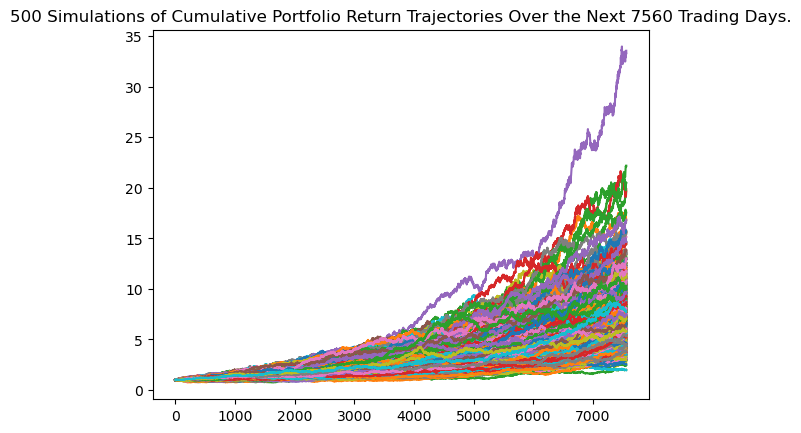

In [19]:
# Plot simulation outcomes
line_plot_oc = mc30cr.plot_simulation()

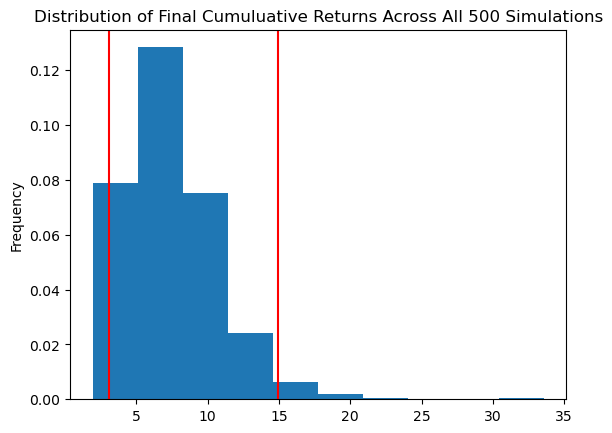

In [20]:
# Plot probability distribution and confidence intervals
prob_dist_plot = mc30cr.plot_distribution()

### Retirement Analysis

In [21]:
# Fetch summary statistics from the Monte Carlo simulation results
summ_stats = mc30cr.summarize_cumulative_return()

# Print summary statistics
print(summ_stats)

count           500.000000
mean              7.479993
std               3.386277
min               1.949949
25%               5.124322
50%               6.760597
75%               9.340324
max              33.568274
95% CI Lower      3.078509
95% CI Upper     14.918047
Name: 7560, dtype: float64


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:172: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return metrics.append(ci_series)


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `$20,000` initial investment.

In [22]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lo = round(summ_stats[8]*initial_investment,2)
ci_hi = round(summ_stats[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lo} and ${ci_hi}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $61570.18 and $298360.94


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [23]:
# Set initial investment
inc_investment = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lo = round(summ_stats[8]*inc_investment,2)
ci_hi = round(summ_stats[9]*inc_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${inc_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lo} and ${ci_hi}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $92355.27 and $447541.41


## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [24]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
mc5cr = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.40,.60],
    num_simulation = 500,
    num_trading_days = 252*5)

# Print the simulation input data
mc5cr.portfolio_data.head()

SPY                                       \
                             open    high     low     close     volume   
timestamp                                                                
2016-05-02 04:00:00+00:00  206.92  208.18  206.41  207.9700   61908515   
2016-05-03 04:00:00+00:00  206.52  206.80  205.28  206.1592  106422142   
2016-05-04 04:00:00+00:00  204.99  205.85  204.42  205.0100   92199810   
2016-05-05 04:00:00+00:00  205.56  205.98  204.47  204.9700   67597222   
2016-05-06 04:00:00+00:00  204.08  205.77  203.88  205.7200   89131004   

                                                                   AGG  \
                          trade_count        vwap daily_return    open   
timestamp                                                                
2016-05-02 04:00:00+00:00      263580  207.294812          NaN  110.74   
2016-05-03 04:00:00+00:00      377518  206.312060    -0.008707  110.89   
2016-05-04 04:00:00+00:00      345261  205.090172    -0.005574  110.91   
2016-05-05 04:00:00+00:00      280622  205.141555    -0.000195  110.92   
2016-05-06 04:00:00+00:00      340335  204.937074     0.003659  111.12   

                                                                             \
                               high       low    close   volume trade_count   
timestamp                                                                     
2016-05-02 04:00:00+00:00  110.7400  110.5200  110.605  3553939       15119   
2016-05-03 04:00:00+00:00  110.9450  110.7500  110.810  3044940       15662   
2016-05-04 04:00:00+00:00  110.9315  110.7595  110.860  2920608       13982   
2016-05-05 04:00:00+00:00  111.1600  110.8010  111.140  3008142       15707   
2016-05-06 04:00:00+00:00  111.1200  110.9700  110.970  2718710       12697   

                                                    
                                 vwap daily_return  
timestamp                                           
2016-05-02 04:00:00+00:00  110.627199          NaN  
2016-05-03 04:00:00+00:00  110.865995     0.001853  
2016-05-04 04:00:00+00:00  110.879063     0.000451  
2016-05-05 04:00:00+00:00  111.028363     0.002526  
2016-05-06 04:00:00+00:00  111.031967    -0.001530

In [25]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
mc5cr.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 110.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 120.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 130.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 140.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 150.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 160.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 170.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 180.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 190.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 200.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 210.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 220.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 230.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 240.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 250.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 260.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 270.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 280.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 290.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 300.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 310.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 320.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 330.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 340.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 350.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 360.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 370.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 380.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 390.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 400.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 410.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 420.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 430.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 440.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 450.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 460.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 470.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 480.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 490.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

0         1         2         3         4         5         6    \
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1     0.993558  1.001718  0.995196  0.993963  1.011900  1.002862  1.000594   
2     0.994414  1.004755  0.990824  0.994279  1.006913  1.004140  0.999058   
3     0.991119  1.017070  1.000218  0.993218  1.011775  1.000999  0.996954   
4     0.996052  1.015545  0.996106  1.006317  1.020404  1.004960  0.983944   
...        ...       ...       ...       ...       ...       ...       ...   
1256  1.541029  1.340904  1.685831  1.464141  1.263962  1.602638  1.673284   
1257  1.538890  1.337292  1.684988  1.473621  1.270629  1.613226  1.669274   
1258  1.526756  1.342879  1.680968  1.479847  1.273157  1.612000  1.673832   
1259  1.525669  1.334358  1.677973  1.486735  1.265106  1.611667  1.681593   
1260  1.520404  1.339591  1.665375  1.476979  1.259410  1.607582  1.688575   

           7         8         9    ...       490       491       492  \
0     1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000   
1     0.993080  0.999081  0.998695  ...  0.989968  0.993002  1.007971   
2     0.993381  0.998836  0.997614  ...  0.993491  0.990303  1.012172   
3     0.994116  0.987276  0.998625  ...  0.999041  0.990588  1.016411   
4     0.988353  0.988306  1.000731  ...  0.997259  0.987385  1.007564   
...        ...       ...       ...  ...       ...       ...       ...   
1256  1.408515  1.475103  1.493182  ...  1.115259  1.711382  1.147028   
1257  1.404380  1.466609  1.481274  ...  1.111423  1.717763  1.153541   
1258  1.398300  1.472106  1.481250  ...  1.100293  1.719368  1.152421   
1259  1.395186  1.475360  1.473502  ...  1.101651  1.706435  1.159674   
1260  1.401098  1.472277  1.474411  ...  1.100627  1.709373  1.166509   

           493       494       495       496       497       498       499  
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
1     1.002298  1.007873  0.998582  1.000744  0.995327  1.010307  1.000394  
2     1.014529  1.006608  0.988793  0.995092  1.000222  1.006007  0.993656  
3     1.007760  1.014315  0.990916  0.988879  0.996874  1.008322  1.001161  
4     1.008153  1.020927  0.991759  0.994286  0.991986  1.015878  0.998748  
...        ...       ...       ...       ...       ...       ...       ...  
1256  1.685308  1.421665  1.159881  1.230673  1.568059  1.783725  1.056801  
1257  1.689591  1.425775  1.163847  1.229346  1.563080  1.795248  1.050654  
1258  1.693696  1.421451  1.163971  1.227800  1.562613  1.779414  1.043199  
1259  1.696766  1.419297  1.163545  1.231493  1.555551  1.778636  1.057533  
1260  1.701009  1.422349  1.162434  1.232953  1.556910  1.794264  1.058789  

[1261 rows x 500 columns]

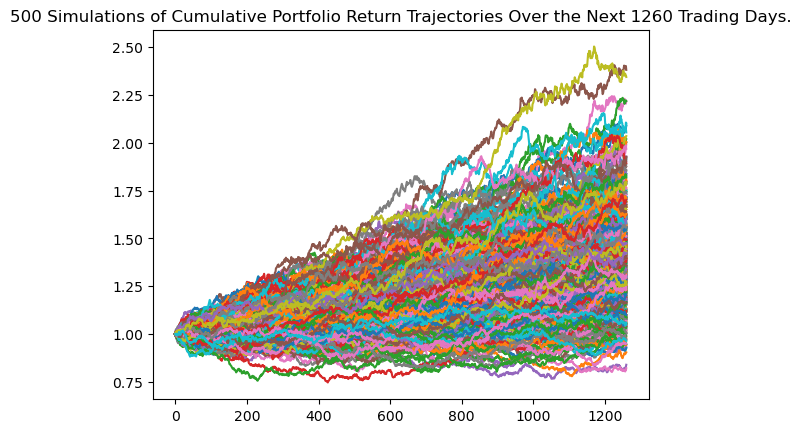

In [28]:
# Plot simulation outcomes
line_plot_oc = mc5cr.plot_simulation()

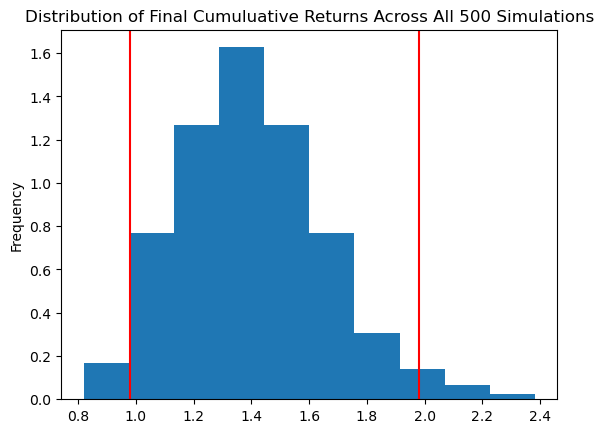

In [29]:
# Plot probability distribution and confidence intervals
dist_plot = mc5cr.plot_distribution()

In [30]:
# Fetch summary statistics from the Monte Carlo simulation results
mc_summ_stat = mc5cr.summarize_cumulative_return()

# Print summary statistics
print(mc_summ_stat)

count           500.000000
mean              1.401753
std               0.254181
min               0.820541
25%               1.218962
50%               1.383719
75%               1.549812
max               2.381325
95% CI Lower      0.980054
95% CI Upper      1.980621
Name: 1260, dtype: float64


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:172: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return metrics.append(ci_series)


In [31]:
# Set initial investment
investment = 60000
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
mc_ci_lower = round(mc_summ_stat[8]*investment,2)
mc_ci_upper = round(mc_summ_stat[9]*investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${mc_ci_lower} and ${mc_ci_upper}")

There is a 95% chance that an initial investment of $60000 in the portfolio over the next 5 years will end within in the range of $58803.25 and $118837.27


### Ten Years Retirement Option

In [32]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
mc10cr = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.40,.60],
    num_simulation = 500,
    num_trading_days = 252*10)

# Print the simulation input data
mc10cr.portfolio_data.head()

SPY                                       \
                             open    high     low     close     volume   
timestamp                                                                
2016-05-02 04:00:00+00:00  206.92  208.18  206.41  207.9700   61908515   
2016-05-03 04:00:00+00:00  206.52  206.80  205.28  206.1592  106422142   
2016-05-04 04:00:00+00:00  204.99  205.85  204.42  205.0100   92199810   
2016-05-05 04:00:00+00:00  205.56  205.98  204.47  204.9700   67597222   
2016-05-06 04:00:00+00:00  204.08  205.77  203.88  205.7200   89131004   

                                                                   AGG  \
                          trade_count        vwap daily_return    open   
timestamp                                                                
2016-05-02 04:00:00+00:00      263580  207.294812          NaN  110.74   
2016-05-03 04:00:00+00:00      377518  206.312060    -0.008707  110.89   
2016-05-04 04:00:00+00:00      345261  205.090172    -0.005574  110.91   
2016-05-05 04:00:00+00:00      280622  205.141555    -0.000195  110.92   
2016-05-06 04:00:00+00:00      340335  204.937074     0.003659  111.12   

                                                                             \
                               high       low    close   volume trade_count   
timestamp                                                                     
2016-05-02 04:00:00+00:00  110.7400  110.5200  110.605  3553939       15119   
2016-05-03 04:00:00+00:00  110.9450  110.7500  110.810  3044940       15662   
2016-05-04 04:00:00+00:00  110.9315  110.7595  110.860  2920608       13982   
2016-05-05 04:00:00+00:00  111.1600  110.8010  111.140  3008142       15707   
2016-05-06 04:00:00+00:00  111.1200  110.9700  110.970  2718710       12697   

                                                    
                                 vwap daily_return  
timestamp                                           
2016-05-02 04:00:00+00:00  110.627199          NaN  
2016-05-03 04:00:00+00:00  110.865995     0.001853  
2016-05-04 04:00:00+00:00  110.879063     0.000451  
2016-05-05 04:00:00+00:00  111.028363     0.002526  
2016-05-06 04:00:00+00:00  111.031967    -0.001530

In [33]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
mc10cr.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 110.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 120.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 130.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 140.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 150.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 160.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 170.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 180.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 190.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 200.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 210.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 220.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 230.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 240.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 250.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 260.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 270.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 280.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 290.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 300.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 310.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 320.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 330.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 340.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 350.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 360.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 370.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 380.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 390.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 400.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 410.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 420.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 430.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 440.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 450.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 460.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 470.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 480.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

Running Monte Carlo simulation number 490.


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly frag

0         1         2         3         4         5         6    \
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1     1.005325  1.002083  1.003620  1.004915  0.991560  0.999525  0.997497   
2     1.013341  0.997753  1.004726  1.008319  0.989993  0.995464  1.008110   
3     1.015388  0.994556  1.008759  1.008897  0.991323  0.991023  1.006312   
4     1.024224  0.986350  1.004802  1.011750  0.993752  0.996625  1.003741   
...        ...       ...       ...       ...       ...       ...       ...   
2516  0.907525  1.592698  1.689724  2.553201  1.538189  1.665096  2.688563   
2517  0.912999  1.585983  1.690572  2.575571  1.533970  1.666013  2.733463   
2518  0.909965  1.585939  1.675000  2.585646  1.532955  1.673534  2.720436   
2519  0.910225  1.594339  1.664946  2.592250  1.536273  1.670021  2.691689   
2520  0.910302  1.603309  1.665206  2.589490  1.545358  1.669149  2.698374   

           7         8         9    ...       490       491       492  \
0     1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000   
1     1.003497  1.010209  0.999804  ...  1.004921  0.999471  1.004956   
2     1.004643  1.007009  1.004267  ...  1.018690  1.006424  1.006943   
3     1.008343  1.010461  1.006909  ...  1.013135  1.011916  1.003535   
4     1.011098  1.004713  1.000250  ...  1.009316  1.006386  1.003796   
...        ...       ...       ...  ...       ...       ...       ...   
2516  2.852762  1.519862  1.706106  ...  1.787683  1.386789  2.409673   
2517  2.848104  1.510405  1.712335  ...  1.795768  1.381646  2.411954   
2518  2.846084  1.504493  1.709847  ...  1.805484  1.375356  2.405548   
2519  2.847254  1.509968  1.726697  ...  1.809293  1.378653  2.393434   
2520  2.862780  1.515507  1.720952  ...  1.797504  1.370071  2.404925   

           493       494       495       496       497       498       499  
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
1     0.993855  0.998594  0.994633  0.999948  0.997204  1.000789  0.998130  
2     0.981465  1.001302  0.992703  0.994512  0.997773  1.002666  1.004112  
3     0.988637  1.009663  0.988453  0.989600  1.002531  1.005791  1.008358  
4     0.984398  1.007124  0.996057  0.992145  0.992177  1.002917  1.012218  
...        ...       ...       ...       ...       ...       ...       ...  
2516  1.656022  2.035275  2.060561  2.447098  1.112592  1.573894  2.375846  
2517  1.652243  2.047466  2.055404  2.455953  1.107195  1.568679  2.389470  
2518  1.652612  2.053214  2.069667  2.470849  1.106668  1.564306  2.409882  
2519  1.645363  2.049602  2.069954  2.479154  1.112501  1.566338  2.417780  
2520  1.636340  2.049568  2.072608  2.470494  1.115007  1.567541  2.429643  

[2521 rows x 500 columns]

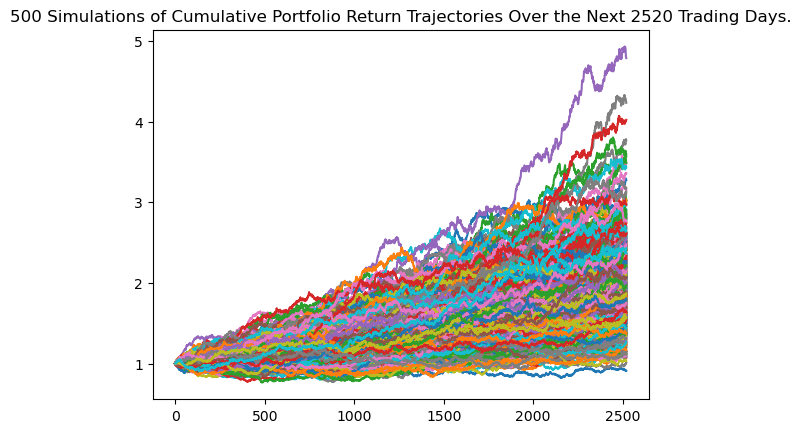

In [35]:
# Plot simulation outcomes
line_plot_oc = mc10cr.plot_simulation()

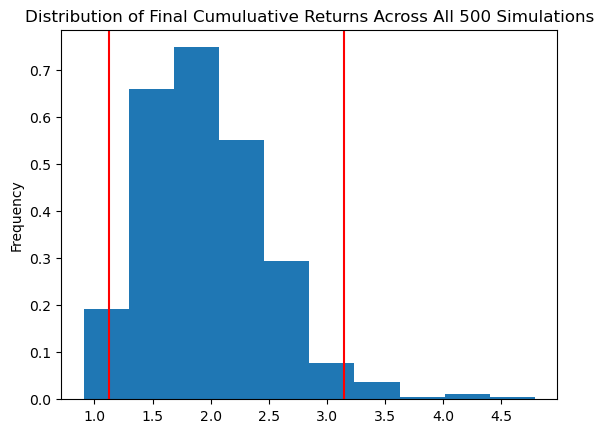

In [36]:
# Plot probability distribution and confidence intervals
dist_plot = mc10cr.plot_distribution()

In [37]:
# Fetch summary statistics from the Monte Carlo simulation results
mc10_summ_stat = mc10cr.summarize_cumulative_return()

# Print summary statistics
print(mc10_summ_stat)

count           500.000000
mean              1.973188
std               0.527939
min               0.910302
25%               1.601877
50%               1.901780
75%               2.271384
max               4.788415
95% CI Lower      1.125209
95% CI Upper      3.144832
Name: 2520, dtype: float64


C:\Users\DanPerowne.KEEPITSIMPLE\GitRepos\bootcamp\finance-plan\MCForecastTools.py:172: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return metrics.append(ci_series)


In [38]:
# Set initial investment
init_inv = 60000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
mc10_lower = round(mc10_summ_stat[8]*init_inv,2)
mc10_upper = round(mc10_summ_stat[9]*init_inv,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${init_inv} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${mc10_lower} and ${mc10_upper}")

There is a 95% chance that an initial investment of $60000 in the portfolio over the next 10 years will end within in the range of $67512.57 and $188689.94
